In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Stock Market Predictor**
# - Uses classification to determine action. (0 for sell, 1 for buy) 
# - Predicts for 5 days, based on 15 day window
# - Uses ensemble classification methods to make prediction 
# - Doesn't require much financial knowledge

Made using inspiration from : https://towardsdatascience.com/predicting-future-stock-market-trends-with-python-machine-learning-2bf3f1633b3c

Some new things we could add to this: 
- Optuna
- Choosing different models/ features
- XGBoost? 
- different window sizes, maybe even 1 because why didn't they use 1. -> a comment on his website said something about having more than 15 windows 
- maybe add another model to the voting classifier
- make while loop into a for loop
- do the feautrue for how much we won/lost programatically 

In [32]:
!pip install yfinance
!pip install finta
## while using datetime, be careful to include the weekends and find some way to circumnavigate that. 

In [33]:
import yfinance as yf
# to get the open, low, high, close data 
from finta import TA
# used for financial feautures - no background information required, can ignore
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score

In [34]:
"""
Defining some constants for data mining
"""

NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'SPY'      # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

[*********************100%***********************]  1 of 1 completed
6890


<AxesSubplot:xlabel='Date'>

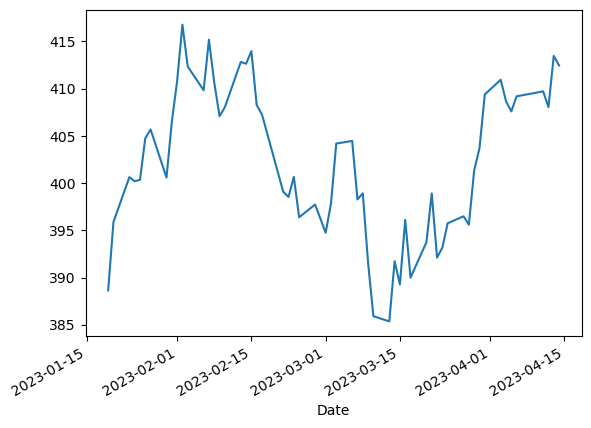

In [35]:
"""
Next we pull the historical data using yfinance
Rename the column names because finta uses the lowercase names
"""

start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
print(len(data))

tmp = data.iloc[-60:]
tmp['close'].plot()

In [37]:
data = data[:-20]
# Removing the last 20 days of data because we need to predict for 5 days, and there is a 15 day rolling window 
# to leave space for the final prediction data

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6870 entries, 1995-11-30 to 2023-03-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       6870 non-null   float64
 1   high       6870 non-null   float64
 2   low        6870 non-null   float64
 3   close      6870 non-null   float64
 4   Adj Close  6870 non-null   float64
 5   volume     6870 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 375.7 KB


<AxesSubplot:xlabel='Date'>

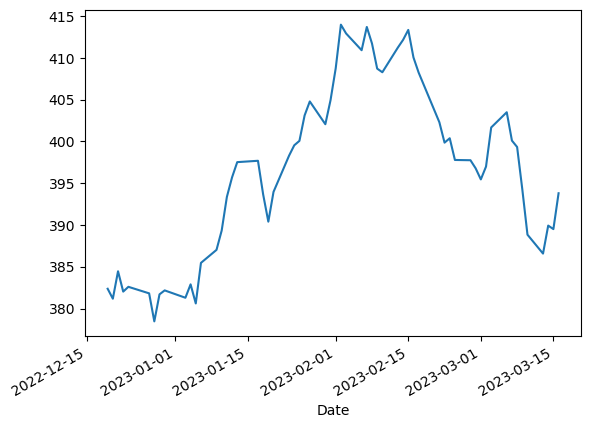

In [40]:
"""
Next we clean our data and perform feature engineering to create new technical indicator features that our
model can learn from
"""

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

data = _exponential_smooth(data, 0.65)

tmp1 = data.iloc[-60:]
tmp1['close'].plot()

In [42]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    
    Can ignore, financial feauture knowledge
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])
    
    return data

data = _get_indicator_data(data)
print(data.columns)

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


In [44]:
def _produce_prediction(data, window):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """
    
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.tail()
print(len(data))

6841


In [47]:
data = data.drop(["14 period RSI", "14 period STOCH %K","14 period ATR","MOM","14 period MFI","ROC","OBV","20 period CCI","14 period EMV","VIm","VIp"],axis=1)
'''
on the last run, there were some columns with null values in the prediction set
because we couldn't the rows, we dropped those feautures from the training data
on subsequent runs, we will drop the columns as they are null
'''
# feauture because British-Korean-Indian.
# Anglo Korean Hindi
# Ankohi
# we speak ankohi
# please upvote :) 


In [48]:

'''Model Training'''
# Split data into equal partitions of size len_train
    
num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
len_train = 40 # Length of each train-test set
    
    # Lists to store the results from each model
rf_RESULTS = []
knn_RESULTS = []
svc_RESULTS = []
ensemble_RESULTS = []
    
i = 0
    
    # Models which will be used
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svc = svm.SVC(probability =True)
    
    # Create a tuple list of our models
estimators=[('knn', knn), ('rf', rf),('svc',svc)]
ensemble = VotingClassifier(estimators, voting='soft')
    
while True:
    try:
        
            # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i*num_train : (i * num_train) + len_train]
        i += 1
            #print(i * num_train, (i * num_train) + len_train)



        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        if len(df) < 40:
            break


            # fit models
        rf.fit(X_train, y_train)
        knn.fit(X_train, y_train)
            #print(df)
        svc.fit(X_train, y_train)
        ensemble.fit(X_train, y_train)

            # get predictions
        rf_prediction = rf.predict(X_test)
        knn_prediction = knn.predict(X_test)
        svc_prediction = svc.predict(X_test)
        ensemble_prediction = ensemble.predict(X_test)

    #         print('rf prediction is ', rf_prediction)
    #         print('knn prediction is ', knn_prediction)
    #         print('ensemble prediction is ', ensemble_prediction)
    #         print('truth values are ', y_test.values)

            # determine accuracy and append to results
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        svc_accuracy = accuracy_score(y_test.values, svc_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)

    #         print(rf_accuracy)
    #         print(knn_accuracy)
    #         print(ensemble_accuracy)
        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        svc_RESULTS.append(svc_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)
    
    except ValueError:
        pass
                
print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
print('SVC: ' + str(sum(svc_RESULTS) / len(svc_RESULTS)))
print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
print('ENSEMBLE Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))
    


RF Accuracy = 0.6109641387419165
SVC: 0.5355673133450908
KNN Accuracy = 0.5946502057613166
ENSEMBLE Accuracy = 0.617430922986479


In [52]:
'''Creating prediction data - dates to predict what action to take'''
last_date = data[-1:]
last_date = last_date.index.to_pydatetime()[0]
pred = pd.DataFrame()
while len(pred.index) != 5:
    end = last_date + datetime.timedelta(days=1)
    d = yf.download(symbol, start=last_date, end=end, interval=INTERVAL)
    last_date = end
    pred = pred.append(d)
pred.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
pred = _exponential_smooth(pred, 0.65)
pred = _get_indicator_data(pred)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SPY: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SPY: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                 close  14 period RSI      MACD    SIGNAL  14 period STOCH %K  \
Date                                                                            
2023-02-23  400.660004            NaN  0.000000  0.000000                 NaN   
2023-02-24  397.489634       0.000000 -0.071130 -0.039517                 NaN   
2023-02-27  397.652878 

In [53]:
pred = pred.drop(["14 period RSI", "14 period STOCH %K","14 period ATR","MOM","14 period MFI","ROC","OBV","20 period CCI","14 period EMV","VIm","VIp"],axis=1)
# matching drop of the data DATAFRAME 
# Hunter WANTED the D and the F to be capitalized
# Please follow :) 

# The 15 day corresponding example
DAy in left Col predictIng action for thE colUmn On the rigHt col
- March 22 : March 1
- March 21 : Feb 28
- March 20 : Feb 27 
- March 17 : Feb 24
- March 16 : Feb 23


Please send help to Hunter, he has Lowcayphobia. 
Comment for more content :) 

# 1 is buy, 0 is sell. 
# That means, that if it is 1, the stock will increase. If 0, stock will decrease. 

In [65]:
pred
del (pred['close'])

In [66]:
prediction = ensemble.predict(pred)
print(prediction)

[1. 1. 1. 1. 1.]


In [67]:
pred

,MACD,SIGNAL,MFV,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,
2023-02-23,0.000000,0.000000,4.642263e+07,1.000000,1.000000,1.000000,1.000000,1.000000
2023-02-24,-0.071130,-0.039517,9.949203e+07,0.996067,0.996120,0.996164,0.996388,1.039816
2023-02-27,-0.085572,-0.058392,7.820379e+07,0.997671,0.997737,0.997793,0.998062,0.919972
2023-02-28,-0.123229,-0.080355,1.833972e+07,0.996554,0.996650,0.996730,0.997117,0.983266
2023-03-01,-0.192937,-0.113846,-1.543996e+07,0.994672,0.994820,0.994944,0.995551,1.017576


We have the predictions! We encourage you to check and see how much money you would have made on the actual day. The stock is 'SPY'. ON April 16, we made $60 
   $ $
 --   --
   \  /
   ---
   ^^ after this we gave up and did: 


In [ ]:
'''

                 .__.__                   _____                              .__  __  .__        ____/\__ ____/\__
  ______ _____ |__|  |   ____ ___.__. _/ ____\____    ____  ____   __  _  _|__|/  |_|  |__    /   / /_//   / /_/
 /  ___//     \|  |  | _/ __ <   |  | \   __\\__  \ _/ ___\/ __ \  \ \/ \/ /  \   __\  |  \   \__/ / \ \__/ / \ 
 \___ \|  Y Y  \  |  |_\  ___/\___  |  |  |   / __ \\  \__\  ___/   \     /|  ||  | |   Y  \  / / /   \/ / /   \
/____  >__|_|  /__|____/\___  > ____|  |__|  (____  /\___  >___  >   \/\_/ |__||__| |___|  / /_/ /__  /_/ /__  /
     \/      \/             \/\/                  \/     \/    \/                        \/    \/   \/  \/   \/ 
     ALL CREDIT TO: https://patorjk.com/software/taag/#p=display&f=Graffiti&t=smiley%20face%20with%20%24%24




'''

# PLEASE UPVOTE WE ARE HIGH SCHOOLERS AND SPENT SPRING BREAK DOING THIS!!
Thanks, XOXO